<a href="https://colab.research.google.com/github/AshishGusain17/via_google_colab/blob/master/chess_players.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn


from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
# from scipy.ndimage import imread

import keras
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [28]:
import h5py
data = h5py.File('/content/drive/My Drive/chess_players/chess_players.h5', "r")
print(np.array(data))
XX = data["X"][:]
Z = data["Z"][:]


num = XX.shape[0] 
print(XX.shape,Z.shape,num)

['X' 'Z']
(552, 224, 224, 3) (552,) 552


In [0]:
imgsize=224

In [30]:
# label_encoder= LabelEncoder()
# Y = label_encoder.fit_transform(Z)
Z = to_categorical(Z,6)
X = XX/255

# print(X)
x_train,x_test,y_train,y_test = train_test_split(X,Z,test_size=0.2,random_state=42)
print(X.shape,Z.shape)

(552, 224, 224, 3) (552, 6)


In [0]:
augs_gen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=20,  
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2, 
        horizontal_flip=True,  
        vertical_flip=False) 

# augs_gen = ImageDataGenerator(vertical_flip=False) 
augs_gen.fit(x_train)

552


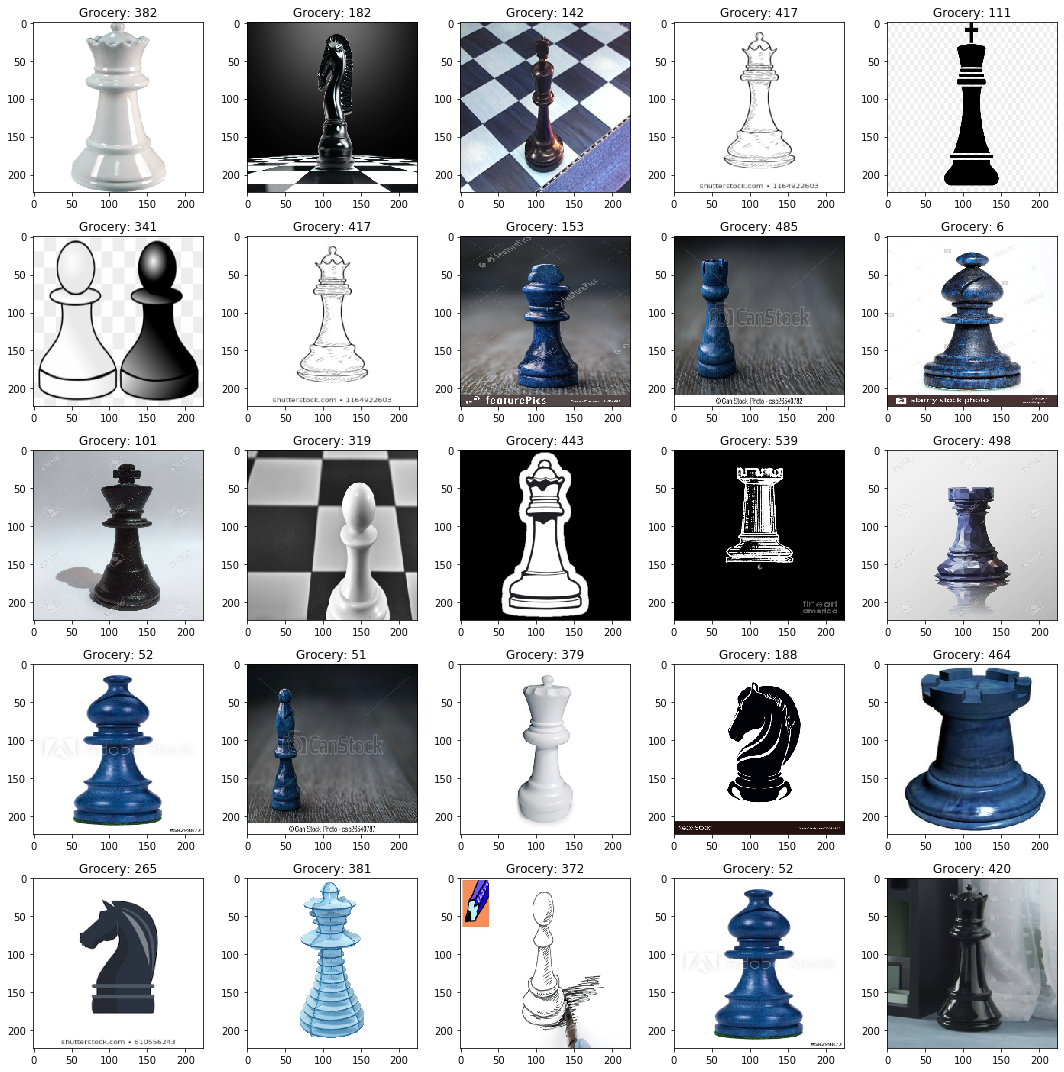

In [32]:
fig,ax=plt.subplots(5,5)
fig.set_size_inches(15,15)
print(len(Z))
for i in range(5):
    for j in range (5):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(XX[l])
        ax[i,j].set_title('Grocery: '+ str(l))
        
plt.tight_layout()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

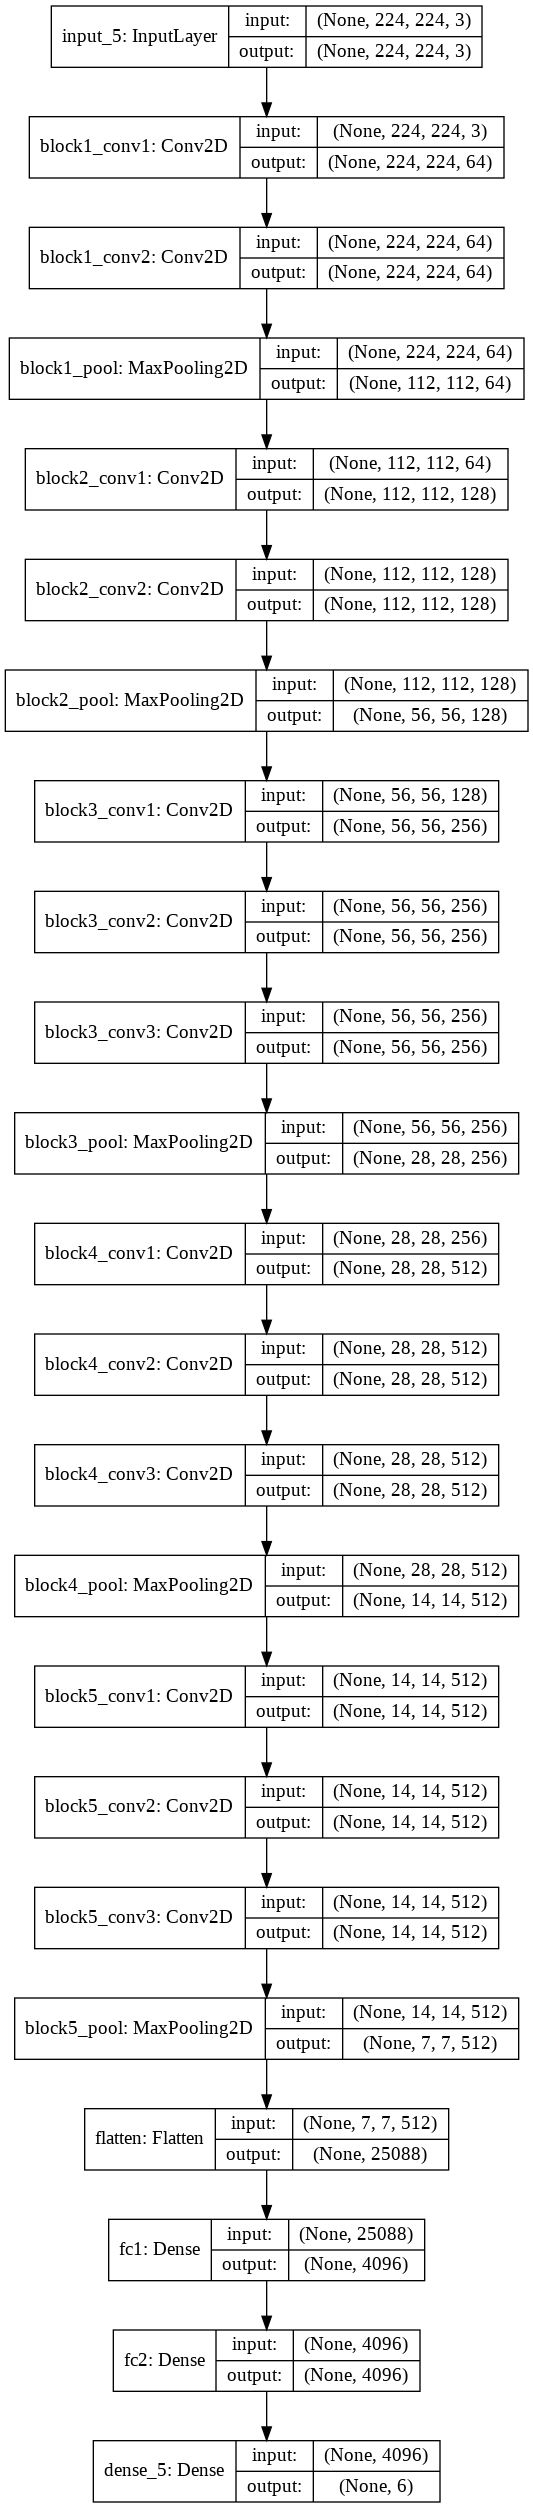

In [37]:
ct=0
base_model = VGG16(include_top=True,
                  input_shape = (imgsize,imgsize,3),
                  weights = 'imagenet')
base_model.summary()
base_model.layers.pop()
model = Sequential()
for layer in base_model.layers:
  model.add(layer)

for layer in base_model.layers:
  ct=ct+1

for layer in base_model.layers:
  if ct>0:
    layer.trainable = False
  else:
    layer.trainable = True
  ct=ct-1
  print(layer,layer.trainable)



# model.add(GlobalAveragePooling2D())
# model.add(Dropout(0.3))
# model.add(Flatten())

# model.add(regularizers.l2(0.01))

model.add(Dense(6,activation='softmax'))
model.summary()

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
checkpoint = ModelCheckpoint(
    './base.model',
    monitor='val_acc',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=50,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]
# callbacks = [earlystop,tensorboard,csvlogger,reduce]

In [39]:

opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=1e-3)

model.compile(
    loss='categorical_crossentropy',
    optimizer=opt1,
    metrics=['accuracy']
)

history = model.fit(
    x_train,y_train,batch_size=32,
    validation_data  = (x_test,y_test),
    # validation_steps = 100,
    # steps_per_epoch  = 10,
    epochs = 180, 
    verbose = 1,
    callbacks=callbacks
)
# history = model.fit_generator(
#     augs_gen.flow(x_train,y_train,batch_size=32),
#     validation_data  = (x_test,y_test),
#     validation_steps = 100,
#     # steps_per_epoch  = 100,
#     epochs =100, 
#     verbose = 1,
#     callbacks=callbacks
# )

Train on 441 samples, validate on 111 samples
Epoch 1/180
441/441 [==============================] - 2s 4ms/step - loss: 2.0822 - acc: 0.1927 - val_loss: 1.7105 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to ./base.model
Epoch 2/180
441/441 [==============================] - 2s 4ms/step - loss: 1.6016 - acc: 0.3583 - val_loss: 1.5534 - val_acc: 0.2703

Epoch 00002: val_acc did not improve from 0.33333
Epoch 3/180
441/441 [==============================] - 2s 4ms/step - loss: 1.5338 - acc: 0.3810 - val_loss: 1.6461 - val_acc: 0.2613

Epoch 00003: val_acc did not improve from 0.33333
Epoch 4/180
441/441 [==============================] - 2s 4ms/step - loss: 1.4725 - acc: 0.4059 - val_loss: 1.4286 - val_acc: 0.3423

Epoch 00004: val_acc improved from 0.33333 to 0.34234, saving model to ./base.model
Epoch 5/180
441/441 [==============================] - 2s 4ms/step - loss: 1.3725 - acc: 0.4535 - val_loss: 1.4794 - val_acc: 0.3694

Epoch 00005: val_ac

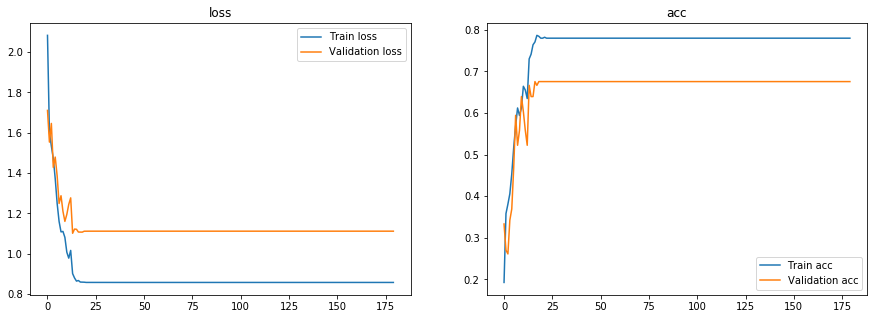

In [40]:
show_final_history(history)
# model.load_weights('./base.model')

# model_json = model.to_json()
# with open("model.json","w") as json_file:
#     json_file.write(model_json)
    
# model.save("model.h5")
# print("Weights Saved")

In [84]:
# use x 
# a=model.evaluate(XX_train,Z_train)
b=model.evaluate(x_train,y_train)
# print(a)
print(b)
ind=0

[0.8585200017812301, 0.7800453518793967]


(552, 6)
(552,)
4 1
0 2
0 3
0 4
0 5
0 6
0 7
3 8
2 9


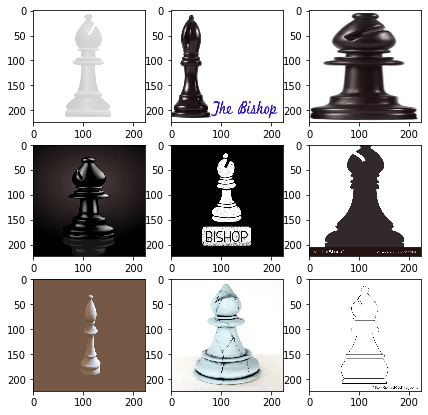

In [88]:
ans=model.predict(X)
print(ans.shape)
ma=np.argmax(ans,axis=1)
print(ma.shape)
plt.figure(figsize=(7,7))

# ind=41
# for i in range(5):
plt.subplot(3,3,1)
plt.imshow(X[ind])
print(ma[ind],1)

plt.subplot(3,3,2)
plt.imshow(X[ind+1])
print(ma[ind+1],2)

plt.subplot(3,3,3)
plt.imshow(X[ind+2])
print(ma[ind+2],3)

plt.subplot(3,3,4)
plt.imshow(X[ind+3])
print(ma[ind+3],4)

plt.subplot(3,3,5)
plt.imshow(X[ind+4])
print(ma[ind+4],5)
plt.subplot(3,3,6)
plt.imshow(X[ind+5])
print(ma[ind+5],6)

plt.subplot(3,3,7)
plt.imshow(X[ind+6])
print(ma[ind+6],7)

plt.subplot(3,3,8)
plt.imshow(X[ind+7])
print(ma[ind+7],8)

plt.subplot(3,3,9)
plt.imshow(X[ind+8])
print(ma[ind+8],9)
ind=ind+8
# plt.subplot(3,3,10)
# plt.imshow(X[ind+9])
# print(ma[i])
# camel   king   horse  sipahi  queen   elephant
  # 0       1      2       3       4        5